# Module 5: USGS Data Retrieval for H&H Modeling
## Accessing Real-World Gauge Data for Model Calibration and Validation 📊🌊

### Welcome to Real-Time Data Integration!
This module teaches you how to access USGS stream gauge data programmatically - essential for model calibration, validation, and real-time operations. By the end, you'll have automated workflows for finding, retrieving, and processing real gauge data.

### What You'll Accomplish Today:
✅ Understand USGS data architecture and parameter codes  
✅ Find gauges within your study watershed  
✅ Retrieve streamflow, stage, and temperature data  
✅ Process time series for H&H model input  
✅ Create professional gauge catalogs  
✅ Build automated data retrieval workflows  
✅ Export data for HEC-RAS and HEC-HMS  

### Module Structure:
1. **Mental Models** - How USGS organizes water data
2. **Data Basics** - Understanding parameter codes and data types
3. **Workspace Setup** - Installing dataretrieval library
4. **Watershed Upload** - Loading your study area
5. **Gauge Discovery** - Finding monitoring locations
6. **Data Retrieval** - Downloading time series
7. **Processing & QC** - Gap filling and resampling
8. **Professional Outputs** - Catalogs and exports
9. **What You Can Now Do** - Complete data workflow

---

## Part 1: Mental Models - USGS Water Data Architecture 🧠

### The USGS National Water Information System (NWIS)

Think of USGS NWIS as a **massive, real-time database** of water measurements across the US:
- **15,000+ active gauges** measuring continuously
- **100+ years** of historical records
- **15-minute updates** for real-time data
- **Free, public access** via web services

### Key Concepts

**1. Site Numbers (Station IDs)**
- Unique 8-15 digit identifier (e.g., "08074500")
- Like a gauge's "social security number"
- Consistent across all USGS databases

**2. Parameter Codes**
- 5-digit codes for measured variables
- Essential codes for H&H:

| Code | Parameter | Units | H&H Use |
|------|-----------|-------|----------|
| 00060 | Discharge (Flow) | cfs | Model calibration |
| 00065 | Gage Height (Stage) | ft | Boundary conditions |
| 00010 | Water Temperature | °C | Water quality |
| 00055 | Stream Velocity | ft/s | Hydraulics |

**3. Data Types**
- **IV (Instantaneous Values)**: 15-minute data for real-time/events
- **DV (Daily Values)**: Daily statistics for long-term analysis

### The Engineering Workflow

```
Your Watershed → Find Nearby Gauges → Retrieve Data → Process → Model Input
```

### Why This Matters

**Manual approach** (what you've been doing):
1. Visit USGS website
2. Click through pages
3. Download CSV files
4. Clean in Excel
5. Format for model
⏰ **Time: 2-4 hours per gauge**

**Automated approach** (what you'll learn today):
1. Run Python script
2. Get all gauges and data
⏰ **Time: 5 minutes for 20+ gauges**

### Today's Scenario

You have a watershed and need:
1. All available gauges within 10 miles
2. Last 5 years of flow and stage data
3. Formatted for HEC-RAS calibration

Let's automate this entire workflow!

## Part 2: Understanding USGS Data Structure 📚

### USGS Web Services

USGS provides data through REST APIs:
- **Base URL**: `https://waterservices.usgs.gov/nwis/`
- **Formats**: JSON, RDB (tab-delimited), WaterML
- **Rate limits**: Be respectful (1 request/second)

### Data Quality Codes

USGS marks data quality:
- **A**: Approved for publication
- **P**: Provisional (subject to revision)
- **e**: Estimated

### Common Issues You'll Handle

1. **Data gaps**: Equipment failure, maintenance
2. **Ice-affected**: Winter measurements unreliable
3. **Datum changes**: Reference elevation shifts
4. **Rating curve updates**: Stage-discharge relationship changes

We'll handle these programmatically!

## Part 3: Setting Up Your Data Retrieval Workspace 🛠️

### Installing the dataretrieval Library

The `dataretrieval` package is maintained by USGS and provides official Python access to NWIS.

In [1]:
# Install USGS data retrieval library and dependencies
!pip install -q dataretrieval geopandas folium requests

print("✅ USGS dataretrieval library installed!")
print("📚 Documentation: https://doi-usgs.github.io/dataretrieval-python/")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
✅ USGS dataretrieval library installed!
📚 Documentation: https://doi-usgs.github.io/dataretrieval-python/


In [4]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import folium
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# USGS dataretrieval
import dataretrieval
import dataretrieval.nwis as nwis

# Set default plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Dataretrieval version: {dataretrieval.__version__ if hasattr(dataretrieval, '__version__') else 'Unknown'}")

Libraries imported successfully!
Dataretrieval version: 1.1.0


### Define USGS Parameter Codes

We'll create a reference dictionary for easy use:

In [5]:
# USGS Parameter codes reference
USGS_PARAMETERS = {
    'discharge': '00060',  # Streamflow in cubic feet per second
    'flow': '00060',       # Alias for discharge
    'stage': '00065',      # Gage height in feet
    'temperature': '00010', # Water temperature in Celsius
    'velocity': '00055',   # Stream velocity in feet per second
    'turbidity': '63680',  # Turbidity in FNU
    'dissolved_oxygen': '00300', # DO in mg/L
    'ph': '00400',         # pH in standard units
    'conductance': '00095' # Specific conductance in uS/cm
}

# Display available parameters
print("Available USGS Parameters:")
print("="*50)
for name, code in USGS_PARAMETERS.items():
    print(f"  {name:20} : {code}")

# Most common for H&H modeling
print("\n🎯 Primary H&H Parameters:")
print("  - Discharge (00060): For model calibration")
print("  - Stage (00065): For boundary conditions")
print("  - Temperature (00010): For water quality models")

Available USGS Parameters:
  discharge            : 00060
  flow                 : 00060
  stage                : 00065
  temperature          : 00010
  velocity             : 00055
  turbidity            : 63680
  dissolved_oxygen     : 00300
  ph                   : 00400
  conductance          : 00095

🎯 Primary H&H Parameters:
  - Discharge (00060): For model calibration
  - Stage (00065): For boundary conditions
  - Temperature (00010): For water quality models


## Part 4: Loading Your Study Watershed 📁

### Upload Watershed Boundary

You can upload either:
- **Shapefile** (as ZIP containing .shp, .shx, .dbf, .prj)
- **GeoJSON** (single file)

This replaces the HDF file approach from RAS Commander.

In [6]:
# Upload watershed boundary file
from google.colab import files

print("📤 Please upload your watershed boundary file:")
print("   Option 1: Shapefile ZIP (contains .shp/.shx/.dbf/.prj)")
print("   Option 2: GeoJSON file")
print("   Option 3: Use the HUC12 watersheds from Module 3/4")
print("\nClick 'Choose Files' below...")

uploaded = files.upload()

print(f"\n✅ Uploaded {len(uploaded)} file(s):")
for filename in uploaded.keys():
    print(f"   - {filename}")

📤 Please upload your watershed boundary file:
   Option 1: Shapefile ZIP (contains .shp/.shx/.dbf/.prj)
   Option 2: GeoJSON file
   Option 3: Use the HUC12 watersheds from Module 3/4

Click 'Choose Files' below...


Saving NHD__Watershed_Boundaries_HUC_12_Selected.zip to NHD__Watershed_Boundaries_HUC_12_Selected.zip

✅ Uploaded 1 file(s):
   - NHD__Watershed_Boundaries_HUC_12_Selected.zip


In [7]:
# Load the watershed boundary
# Determine file type and load accordingly

uploaded_files = list(uploaded.keys())

if any('.zip' in f for f in uploaded_files):
    # Handle shapefile ZIP
    zip_file = [f for f in uploaded_files if '.zip' in f][0]
    print(f"Loading shapefile from {zip_file}...")
    watersheds = gpd.read_file(f'zip://{zip_file}')
elif any('.geojson' in f.lower() or '.json' in f.lower() for f in uploaded_files):
    # Handle GeoJSON
    json_file = [f for f in uploaded_files if '.geojson' in f.lower() or '.json' in f.lower()][0]
    print(f"Loading GeoJSON from {json_file}...")
    watersheds = gpd.read_file(json_file)
else:
    print("⚠️ No recognized file format. Please upload a shapefile ZIP or GeoJSON.")

print(f"\n✅ Loaded {len(watersheds)} watershed(s)")
print(f"CRS: {watersheds.crs}")
print(f"\nAvailable attributes:")
for col in watersheds.columns:
    if col != 'geometry':
        print(f"  - {col}: {watersheds[col].iloc[0]}")

watersheds.head()

Loading shapefile from NHD__Watershed_Boundaries_HUC_12_Selected.zip...

✅ Loaded 19 watershed(s)
CRS: EPSG:3857

Available attributes:
  - OBJECTID_1: 403
  - TNMID: {5046D1CD-AB91-4314-9C85-6B1F641344D3}
  - MetaSource: {FF24B7E9-B918-4635-ADDB-267C27FDD7E0}
  - SourceData: None
  - SourceOrig: None
  - SourceFeat: None
  - LoadDate: 2017-07-20 00:00:00
  - GNIS_ID: 0
  - AreaAcres: 62972.71
  - AreaSqKm: 254.84
  - States: CO,WY
  - HUC12: 101900090302
  - Name: Town of Carpenter-Crow Creek
  - HUType: S
  - HUMod: IT
  - ToHUC: 101900090303
  - NonContrib: 0.0
  - NonContr_1: 0.0
  - Shape_Leng: 189989.7442
  - Shape_Area: 448744258.278


,OBJECTID_1,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,...,HUC12,Name,HUType,HUMod,ToHUC,NonContrib,NonContr_1,Shape_Leng,Shape_Area,geometry
0,403,{5046D1CD-AB91-4314-9C85-6B1F641344D3},{FF24B7E9-B918-4635-ADDB-267C27FDD7E0},None,None,None,2017-07-20,0,62972.71,254.84,...,101900090302,Town of Carpenter-Crow Creek,S,IT,101900090303,0.0,0.0,189989.744200,4.487443e+08,"POLYGON ((-11657392.686 5035793.9, -11657316.9..."
1,407,{7D2C193F-CB7C-420E-B3E1-935D87CB0B28},{C101E8B4-4601-4734-90D2-0FF4D2429119},None,None,None,2013-01-18,0,38718.27,156.69,...,101900090203,Upper Little Crow Creek,S,NM,101900090208,0.0,0.0,168836.768892,2.756072e+08,"POLYGON ((-11639279.886 5020950.114, -11639099..."
2,408,{F907605E-9050-43B0-BA43-6F9CC35B4861},{C101E8B4-4601-4734-90D2-0FF4D2429119},None,None,None,2013-01-18,0,16408.44,66.40,...,101900090202,Lower Simpson Creek,S,NM,101900090203,0.0,0.0,93372.088509,1.166151e+08,"POLYGON ((-11621308.46 4999543.657, -11621413...."
3,411,{E00945CD-089D-45AF-AFEE-644138524913},{C101E8B4-4601-4734-90D2-0FF4D2429119},None,None,None,2013-01-18,0,32269.92,130.59,...,101900090201,Upper Simpson Creek,S,NM,101900090202,0.0,0.0,92078.031540,2.295243e+08,"POLYGON ((-11651076.414 5017615.713, -11651055..."
4,429,{27CB4A52-26AB-43A3-AFC0-82CB33784613},{C101E8B4-4601-4734-90D2-0FF4D2429119},None,None,None,2013-01-18,0,32960.98,133.39,...,101900090106,Spring Creek-Crow Creek,S,IT,101900090109,0.0,0.0,82545.299482,2.355216e+08,"POLYGON ((-11680683.65 5042658.84, -11680681.8..."


### Select Your Study Watershed

Choose one watershed to focus on (same approach as Modules 3-4):

In [8]:
# Option 1: Select by index (change the number to select different watershed)
watershed_index = 0  # First watershed

# Option 2: If you have HUC12 data, you can select by HUC code
# target_huc = '101900090108'  # Example from Module 3/4
# huc_col = [col for col in watersheds.columns if 'huc' in col.lower() or 'HUC' in col][0]
# selected_watershed = watersheds[watersheds[huc_col] == target_huc]

# For this example, we'll use index selection
selected_watershed = watersheds.iloc[[watershed_index]].copy()

print("Selected watershed:")
for col in selected_watershed.columns:
    if col != 'geometry':
        print(f"  {col}: {selected_watershed[col].values[0]}")

# Calculate watershed area
if selected_watershed.crs and selected_watershed.crs.is_projected:
    area_km2 = selected_watershed.geometry.area.values[0] / 1_000_000
    print(f"\nWatershed area: {area_km2:.2f} km²")
else:
    print("\n⚠️ Watershed in geographic CRS - will reproject for area calculation")

Selected watershed:
  OBJECTID_1: 403
  TNMID: {5046D1CD-AB91-4314-9C85-6B1F641344D3}
  MetaSource: {FF24B7E9-B918-4635-ADDB-267C27FDD7E0}
  SourceData: None
  SourceOrig: None
  SourceFeat: None
  LoadDate: 2017-07-20T00:00:00.000
  GNIS_ID: 0
  AreaAcres: 62972.71
  AreaSqKm: 254.84
  States: CO,WY
  HUC12: 101900090302
  Name: Town of Carpenter-Crow Creek
  HUType: S
  HUMod: IT
  ToHUC: 101900090303
  NonContrib: 0.0
  NonContr_1: 0.0
  Shape_Leng: 189989.7442
  Shape_Area: 448744258.278

Watershed area: 448.74 km²


## Part 5: CRS Normalization and Buffering 🌍

### Critical Step: Ensure Proper Coordinate System

For accurate buffering, we need a projected CRS (meters/feet), not geographic (degrees).

In [9]:
# Check and reproject if needed
if selected_watershed.crs is None:
    print("⚠️ No CRS defined. Assuming WGS84 (EPSG:4326)")
    selected_watershed = selected_watershed.set_crs('EPSG:4326')

if not selected_watershed.crs.is_projected:
    print(f"Current CRS is geographic ({selected_watershed.crs})")

    # Find appropriate UTM zone
    centroid = selected_watershed.geometry.centroid.values[0]
    lon = centroid.x
    utm_zone = int((lon + 180) / 6) + 1

    # Determine hemisphere
    if centroid.y >= 0:
        epsg_code = 32600 + utm_zone  # Northern hemisphere
    else:
        epsg_code = 32700 + utm_zone  # Southern hemisphere

    print(f"Reprojecting to UTM Zone {utm_zone} (EPSG:{epsg_code})...")
    selected_watershed_proj = selected_watershed.to_crs(f'EPSG:{epsg_code}')
else:
    print(f"Already in projected CRS: {selected_watershed.crs}")
    selected_watershed_proj = selected_watershed.copy()

# Now calculate accurate area
area_km2 = selected_watershed_proj.geometry.area.values[0] / 1_000_000
print(f"\n✅ Watershed area: {area_km2:.2f} km²")

Already in projected CRS: EPSG:3857

✅ Watershed area: 448.74 km²


### Apply Buffer Around Watershed

Buffer helps capture gauges just outside the watershed that might be relevant:

In [10]:
# Define buffer distance
buffer_distance_km = 10  # Adjust as needed (5-20 km typical)
buffer_distance_m = buffer_distance_km * 1000

print(f"Applying {buffer_distance_km} km buffer around watershed...")

# Create buffered geometry
buffered_watershed_proj = selected_watershed_proj.copy()
buffered_watershed_proj['geometry'] = selected_watershed_proj.geometry.buffer(buffer_distance_m)

# Calculate buffered area
buffered_area_km2 = buffered_watershed_proj.geometry.area.values[0] / 1_000_000

print(f"Original area: {area_km2:.2f} km²")
print(f"Buffered area: {buffered_area_km2:.2f} km²")
print(f"Search area increased by: {((buffered_area_km2/area_km2 - 1) * 100):.1f}%")

# Reproject both to WGS84 for USGS queries
selected_watershed_wgs = selected_watershed_proj.to_crs('EPSG:4326')
buffered_watershed_wgs = buffered_watershed_proj.to_crs('EPSG:4326')

Applying 10 km buffer around watershed...
Original area: 448.74 km²
Buffered area: 2246.23 km²
Search area increased by: 400.6%


### Visualize Watershed and Buffer

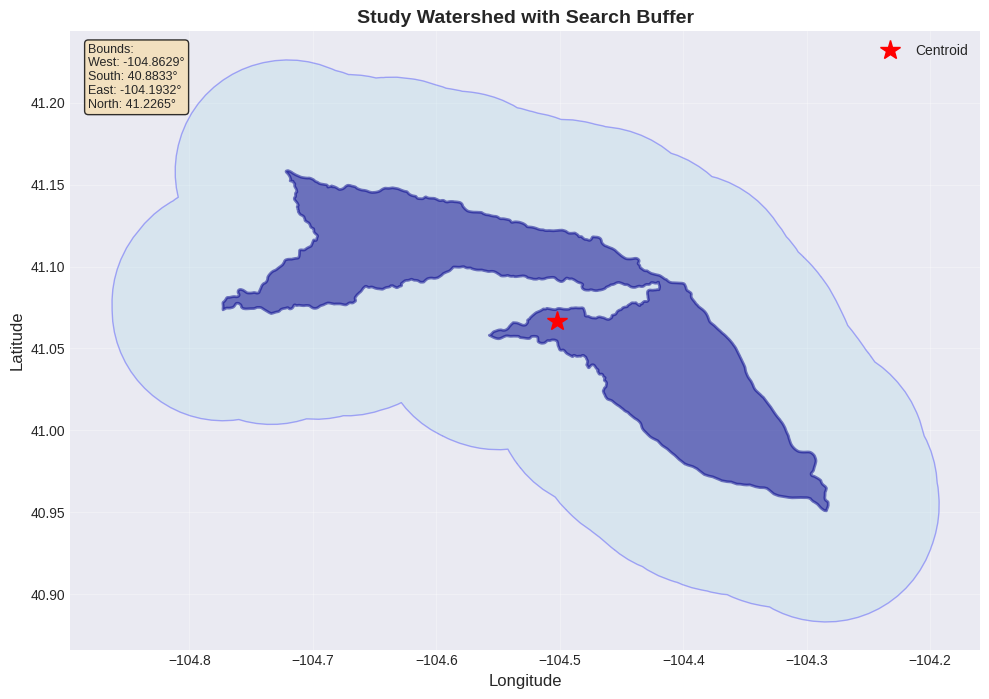

In [11]:
# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot buffered area
buffered_watershed_wgs.plot(ax=ax, color='lightblue', alpha=0.3,
                            edgecolor='blue', linewidth=1,
                            label=f'{buffer_distance_km}km Buffer')

# Plot original watershed
selected_watershed_wgs.plot(ax=ax, color='darkblue', alpha=0.5,
                           edgecolor='darkblue', linewidth=2,
                           label='Study Watershed')

# Add centroid
centroid = selected_watershed_wgs.geometry.centroid.values[0]
ax.plot(centroid.x, centroid.y, 'r*', markersize=15, label='Centroid')

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Study Watershed with Search Buffer', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Add coordinate labels
bounds = buffered_watershed_wgs.total_bounds
ax.text(0.02, 0.98, f'Bounds:\n'
       f'West: {bounds[0]:.4f}°\n'
       f'South: {bounds[1]:.4f}°\n'
       f'East: {bounds[2]:.4f}°\n'
       f'North: {bounds[3]:.4f}°',
       transform=ax.transAxes,
       verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
       fontsize=9)

plt.tight_layout()
plt.show()

## Part 6: Finding USGS Gauges in Your Area 🔍

### Query USGS for Monitoring Locations

We'll use the bounding box of our buffered watershed to find gauges:

In [12]:
# Get bounding box for USGS query
west, south, east, north = buffered_watershed_wgs.total_bounds

print(f"Searching for USGS gauges in bounding box:")
print(f"  West: {west:.4f}°")
print(f"  South: {south:.4f}°")
print(f"  East: {east:.4f}°")
print(f"  North: {north:.4f}°")

# Query USGS for sites in bounding box
# We'll look for sites with discharge (00060) OR stage (00065) data
try:
    print("\nQuerying USGS NWIS for monitoring locations...")

    # Get sites with discharge data
    sites_df, _ = nwis.get_info(
        bBox=f"{west:.6f},{south:.6f},{east:.6f},{north:.6f}",
        parameterCd='00060,00065',  # Discharge and stage
        siteType='ST',  # Stream sites
        siteStatus='all'  # Include both active and inactive
    )

    if len(sites_df) > 0:
        print(f"\n✅ Found {len(sites_df)} USGS gauge(s) in bounding box")

        # Convert to GeoDataFrame
        sites_gdf = gpd.GeoDataFrame(
            sites_df,
            geometry=gpd.points_from_xy(sites_df.dec_long_va, sites_df.dec_lat_va),
            crs='EPSG:4326'
        )

        # Display basic info
        print("\nGauge summary:")
        print(sites_gdf[['site_no', 'station_nm', 'dec_lat_va', 'dec_long_va']].head(10))
    else:
        print("\n⚠️ No USGS gauges found in bounding box")
        print("Try increasing the buffer distance or checking a different area.")
        sites_gdf = gpd.GeoDataFrame()  # Empty GeoDataFrame

except Exception as e:
    print(f"\n❌ Error querying USGS: {str(e)}")
    print("This might be due to network issues or API limitations.")
    sites_gdf = gpd.GeoDataFrame()

Searching for USGS gauges in bounding box:
  West: -104.8629°
  South: 40.8833°
  East: -104.1932°
  North: 41.2265°

Querying USGS NWIS for monitoring locations...

✅ Found 4 USGS gauge(s) in bounding box

Gauge summary:
    site_no                                    station_nm  dec_lat_va  \
0  06755950  CROW CREEK AT F.E. WARREN AIR FORCE BASE, WY   41.133871   
1  06755960    CROW CREEK AT 19TH STREET, AT CHEYENNE, WY   41.131333   
2  06756000                  CROW CREEK NEAR CHEYENNE, WY   41.119130   
3  06756100                 CROW CREEK NEAR CARPENTER, WY   41.082760   

   dec_long_va  
0  -104.840802  
1  -104.828917  
2  -104.759741  
3  -104.399402  


### Spatial Filter: Keep Only Gauges Within Buffer

The bounding box query returns a rectangle - we need to filter to our actual buffered shape:

In [13]:
if len(sites_gdf) > 0:
    # Spatial filter - keep only points within buffered watershed
    print(f"Filtering {len(sites_gdf)} gauges to buffered watershed...")

    # Perform spatial join
    sites_in_buffer = sites_gdf[sites_gdf.within(buffered_watershed_wgs.geometry.values[0])]

    print(f"\n✅ {len(sites_in_buffer)} gauge(s) within buffered watershed")

    if len(sites_in_buffer) > 0:
        # Further classify: inside watershed vs in buffer zone
        sites_in_watershed = sites_in_buffer[sites_in_buffer.within(selected_watershed_wgs.geometry.values[0])]
        sites_in_buffer_only = sites_in_buffer[~sites_in_buffer.within(selected_watershed_wgs.geometry.values[0])]

        print(f"  - {len(sites_in_watershed)} directly in watershed")
        print(f"  - {len(sites_in_buffer_only)} in buffer zone")

        # Add location type
        sites_in_buffer['location_type'] = 'buffer'
        sites_in_buffer.loc[sites_in_watershed.index, 'location_type'] = 'watershed'
    else:
        print("\n⚠️ No gauges found within the buffered area.")
        print("Consider increasing the buffer distance.")
else:
    sites_in_buffer = gpd.GeoDataFrame()
    print("\n⚠️ No gauges to filter.")

Filtering 4 gauges to buffered watershed...

✅ 3 gauge(s) within buffered watershed
  - 1 directly in watershed
  - 2 in buffer zone


### Calculate Distances and Rank Gauges

In [14]:
if len(sites_in_buffer) > 0:
    # Project to UTM for accurate distance calculation
    sites_projected = sites_in_buffer.to_crs(selected_watershed_proj.crs)
    watershed_centroid_proj = selected_watershed_proj.geometry.centroid.values[0]

    # Calculate distance to watershed centroid
    sites_in_buffer['distance_km'] = sites_projected.geometry.distance(watershed_centroid_proj) / 1000

    # Sort by distance
    sites_in_buffer = sites_in_buffer.sort_values('distance_km')

    # Add ranking
    sites_in_buffer['rank'] = range(1, len(sites_in_buffer) + 1)

    print("\nRANKED GAUGES (by distance from watershed center):")
    print("="*70)

    for idx, row in sites_in_buffer.head(10).iterrows():
        print(f"Rank {row['rank']}: {row['site_no']} - {row['station_nm'][:40]}")
        print(f"         Distance: {row['distance_km']:.1f} km | Type: {row['location_type']}")
        if pd.notna(row.get('drain_area_va', None)):
            print(f"         Drainage area: {row['drain_area_va']:.1f} sq mi")
        print()


RANKED GAUGES (by distance from watershed center):
Rank 1: 06756100 - CROW CREEK NEAR CARPENTER, WY
         Distance: 11.7 km | Type: watershed
         Drainage area: 415.0 sq mi

Rank 2: 06756000 - CROW CREEK NEAR CHEYENNE, WY
         Distance: 29.6 km | Type: buffer
         Drainage area: 294.0 sq mi

Rank 3: 06755960 - CROW CREEK AT 19TH STREET, AT CHEYENNE, 
         Distance: 37.5 km | Type: buffer
         Drainage area: 260.0 sq mi



### Visualize Gauges on Map

In [15]:
if len(sites_in_buffer) > 0:
    # Create interactive map
    center_lat = selected_watershed_wgs.geometry.centroid.y.values[0]
    center_lon = selected_watershed_wgs.geometry.centroid.x.values[0]

    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    # Add watershed
    folium.GeoJson(
        selected_watershed_wgs.geometry.values[0],
        style_function=lambda x: {
            'fillColor': 'darkblue',
            'color': 'darkblue',
            'weight': 2,
            'fillOpacity': 0.3
        },
        tooltip="Study Watershed"
    ).add_to(m)

    # Add buffer
    folium.GeoJson(
        buffered_watershed_wgs.geometry.values[0],
        style_function=lambda x: {
            'fillColor': 'lightblue',
            'color': 'blue',
            'weight': 1,
            'fillOpacity': 0.1
        },
        tooltip=f"{buffer_distance_km}km Buffer"
    ).add_to(m)

    # Add gauges
    for idx, gauge in sites_in_buffer.iterrows():
        color = 'green' if gauge['location_type'] == 'watershed' else 'orange'
        icon = 'tint' if gauge['location_type'] == 'watershed' else 'info-sign'

        folium.Marker(
            location=[gauge.geometry.y, gauge.geometry.x],
            popup=f"<b>{gauge['site_no']}</b><br>{gauge['station_nm']}<br>Distance: {gauge['distance_km']:.1f} km",
            tooltip=f"{gauge['site_no']}: {gauge['station_nm']}",
            icon=folium.Icon(color=color, icon=icon)
        ).add_to(m)

    # Display map
    print("Interactive map of USGS gauges:")
    print("🟢 Green = Inside watershed | 🟠 Orange = In buffer zone")
    display(m)
else:
    print("No gauges to map.")

Interactive map of USGS gauges:
🟢 Green = Inside watershed | 🟠 Orange = In buffer zone


## Part 7: Retrieving Time Series Data 📈

### Check Data Availability

First, let's see what data is available at our gauges:

In [31]:
from dataretrieval import nwis
import pandas as pd

# Key USGS parameter codes you care about
KEY_PARAMS = ["00060", "00065", "00010", "00055"]

if len(sites_in_buffer) > 0:
    # Select top gauge for demonstration
    top_gauge = sites_in_buffer.iloc[0]
    site_no = str(top_gauge["site_no"])

    print(f"Checking data availability for gauge {site_no}:")
    print(f"Station: {top_gauge.get('station_nm', 'Unknown')}\n")

    # 1) Use get_info(..., seriesCatalogOutput=True) to see what series exist at this site
    # 2) Use get_pmcodes(parameterCd=...) only to translate codes to names/units
    try:
        info_df, _ = nwis.get_info(sites=site_no, seriesCatalogOutput=True)

        if info_df is None or len(info_df) == 0:
            print("No series catalog information returned for this gauge.")
        else:
            # Try to standardize column names that commonly show up in the series catalog output.
            # (The exact column names can vary by service response.)
            cols = {c.lower(): c for c in info_df.columns}

            # Parameter code column candidates
            param_col = (
                cols.get("parm_cd")
                or cols.get("parameter_cd")
                or cols.get("parametercode")
                or cols.get("parameter code")
            )

            # Begin/end date column candidates
            begin_col = (
                cols.get("begin_date")
                or cols.get("begindate")
                or cols.get("begin date")
                or cols.get("start_dt")
                or cols.get("startdate")
            )
            end_col = (
                cols.get("end_date")
                or cols.get("enddate")
                or cols.get("end date")
                or cols.get("end_dt")
            )

            # Data type column candidates (iv/dv)
            dtype_col = (
                cols.get("data_type_cd")
                or cols.get("datatype")
                or cols.get("data type")
                or cols.get("service")
            )

            # If we can't even identify a parameter code column, show user what came back
            if not param_col:
                print("Could not identify the parameter code column in the series catalog output.")
                print("Returned columns:", list(info_df.columns))
            else:
                # Filter to your key parameter codes
                info_key = info_df[info_df[param_col].astype(str).isin(KEY_PARAMS)].copy()

                if len(info_key) == 0:
                    print("None of the key parameters were found in the series catalog output for this gauge.")
                else:
                    # Pull friendly parameter names/units from get_pmcodes
                    pm_df, _ = nwis.get_pmcodes(parameterCd=KEY_PARAMS, partial=False)

                    # Standardize pm_df columns
                    pm_cols = {c.lower(): c for c in pm_df.columns}
                    pm_code_col = pm_cols.get("parameter_cd") or pm_cols.get("parm_cd")
                    pm_name_col = pm_cols.get("parm_nm") or pm_cols.get("parameter_name")
                    pm_unit_col = pm_cols.get("parm_unit") or pm_cols.get("parameter_units")

                    # Build a lookup dict: code -> (name, units)
                    code_to_meta = {}
                    if pm_code_col:
                        for _, r in pm_df.iterrows():
                            code = str(r.get(pm_code_col, "")).strip()
                            name = r.get(pm_name_col, "") if pm_name_col else ""
                            unit = r.get(pm_unit_col, "") if pm_unit_col else ""
                            if code:
                                code_to_meta[code] = (name, unit)

                    print("Available key parameters at this gauge:")
                    print("=" * 50)

                    # Keep output order consistent with KEY_PARAMS
                    for param_code in KEY_PARAMS:
                        rows = info_key[info_key[param_col].astype(str) == param_code]
                        if len(rows) == 0:
                            continue

                        # Friendly name/units (if available)
                        pname, punit = code_to_meta.get(param_code, ("", ""))
                        label = f"{pname} ({punit})".strip()
                        if not label or label == "()":
                            label = "Unknown parameter"

                        print(f"  {param_code}: {label}")

                        # Some sites will have multiple series for the same parameter (iv vs dv, multiple time spans)
                        for _, s in rows.iterrows():
                            dtype = s.get(dtype_col, None) if dtype_col else None
                            begin = s.get(begin_col, None) if begin_col else None
                            end = s.get(end_col, None) if end_col else None

                            # Clean printing
                            dtype_str = f"{dtype}".strip() if pd.notna(dtype) else "unknown-type"
                            begin_str = f"{begin}".strip() if pd.notna(begin) else "unknown-start"
                            end_str = f"{end}".strip() if pd.notna(end) else "present/unknown-end"

                            print(f"         Type: {dtype_str} | Period: {begin_str} to {end_str}")

                        print()

    except Exception as e:
        print(f"Could not retrieve parameter/series information: {e}")

else:
    print("No gauges available for data retrieval.")


Checking data availability for gauge 06756100:
Station: CROW CREEK NEAR CARPENTER, WY

Available key parameters at this gauge:
  00060: Discharge, cubic feet per second (ft3/s)
         Type: dv | Period: 1990-05-01 to 1996-09-30
         Type: uv | Period: 1991-08-27 to 1996-09-30

  00010: Temperature, water, degrees Celsius (deg C)
         Type: qw | Period: 1990-08-29 to 1992-08-21



### Retrieve Flow (Discharge) Data

In [18]:
if len(sites_in_buffer) > 0:
    # Define time period for data retrieval
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*2)  # Last 2 years

    print(f"Retrieving discharge data for {site_no}")
    print(f"Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    try:
        # Retrieve instantaneous values (15-minute data)
        flow_df, metadata = nwis.get_iv(
            sites=site_no,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            parameterCd='00060'  # Discharge
        )

        if len(flow_df) > 0:
            print(f"\n✅ Retrieved {len(flow_df)} discharge measurements")

            # Display summary statistics
            discharge_col = [col for col in flow_df.columns if '00060' in col][0]

            print("\nDISCHARGE STATISTICS:")
            print("="*40)
            print(f"Minimum: {flow_df[discharge_col].min():.1f} cfs")
            print(f"Maximum: {flow_df[discharge_col].max():.1f} cfs")
            print(f"Mean: {flow_df[discharge_col].mean():.1f} cfs")
            print(f"Median: {flow_df[discharge_col].median():.1f} cfs")

            # Check for data gaps
            time_diff = flow_df.index.to_series().diff()
            expected_interval = pd.Timedelta(minutes=15)
            gaps = time_diff[time_diff > expected_interval * 2]

            if len(gaps) > 0:
                print(f"\n⚠️ Found {len(gaps)} data gaps")
                if len(gaps) <= 5:
                    print("Gap locations:")
                    for gap_time, gap_duration in gaps.head().items():
                        print(f"  {gap_time}: {gap_duration}")
        else:
            print("\n⚠️ No discharge data available for this period")
            flow_df = pd.DataFrame()

    except Exception as e:
        print(f"\n❌ Error retrieving discharge data: {e}")
        flow_df = pd.DataFrame()
else:
    flow_df = pd.DataFrame()

Retrieving discharge data for 06756100
Period: 2023-12-26 to 2025-12-25

⚠️ No discharge data available for this period


### Retrieve Stage (Water Level) Data

In [ ]:
if len(sites_in_buffer) > 0:
    print(f"Retrieving stage data for {site_no}")

    try:
        # Retrieve stage data
        stage_df, metadata = nwis.get_iv(
            sites=site_no,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            parameterCd='00065'  # Gage height
        )

        if len(stage_df) > 0:
            print(f"\n✅ Retrieved {len(stage_df)} stage measurements")

            # Display summary statistics
            stage_col = [col for col in stage_df.columns if '00065' in col][0]

            print("\nSTAGE STATISTICS:")
            print("="*40)
            print(f"Minimum: {stage_df[stage_col].min():.2f} ft")
            print(f"Maximum: {stage_df[stage_col].max():.2f} ft")
            print(f"Mean: {stage_df[stage_col].mean():.2f} ft")
            print(f"Range: {stage_df[stage_col].max() - stage_df[stage_col].min():.2f} ft")
        else:
            print("\n⚠️ No stage data available for this period")
            stage_df = pd.DataFrame()

    except Exception as e:
        print(f"\n❌ Error retrieving stage data: {e}")
        stage_df = pd.DataFrame()
else:
    stage_df = pd.DataFrame()

### Visualize Retrieved Time Series

In [ ]:
if len(flow_df) > 0 or len(stage_df) > 0:
    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot discharge
    if len(flow_df) > 0:
        discharge_col = [col for col in flow_df.columns if '00060' in col][0]
        axes[0].plot(flow_df.index, flow_df[discharge_col],
                    color='blue', linewidth=0.5, alpha=0.8)
        axes[0].set_ylabel('Discharge (cfs)', fontsize=12)
        axes[0].set_title(f'USGS {site_no}: {top_gauge["station_nm"]}',
                         fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)

        # Add statistics
        axes[0].axhline(y=flow_df[discharge_col].mean(),
                       color='red', linestyle='--', alpha=0.5,
                       label=f'Mean: {flow_df[discharge_col].mean():.1f} cfs')
        axes[0].legend(loc='upper right')

    # Plot stage
    if len(stage_df) > 0:
        stage_col = [col for col in stage_df.columns if '00065' in col][0]
        axes[1].plot(stage_df.index, stage_df[stage_col],
                    color='green', linewidth=0.5, alpha=0.8)
        axes[1].set_ylabel('Stage (ft)', fontsize=12)
        axes[1].set_xlabel('Date', fontsize=12)
        axes[1].grid(True, alpha=0.3)

        # Add statistics
        axes[1].axhline(y=stage_df[stage_col].mean(),
                       color='red', linestyle='--', alpha=0.5,
                       label=f'Mean: {stage_df[stage_col].mean():.2f} ft')
        axes[1].legend(loc='upper right')

    # Format x-axis
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)

    plt.suptitle('USGS Gauge Time Series Data', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No time series data to visualize.")

## Part 8: Data Processing and Quality Control 🔧

### Resample to Model Time Step

Convert 15-minute data to hourly or daily for model input:

In [ ]:
if len(flow_df) > 0:
    discharge_col = [col for col in flow_df.columns if '00060' in col][0]

    # Resample to hourly
    flow_hourly = flow_df[[discharge_col]].resample('1H').mean()
    flow_hourly.columns = ['discharge_cfs']

    # Resample to daily
    flow_daily = flow_df[[discharge_col]].resample('1D').mean()
    flow_daily.columns = ['discharge_cfs']

    print("DATA RESAMPLING:")
    print("="*40)
    print(f"Original (15-min): {len(flow_df)} records")
    print(f"Hourly: {len(flow_hourly)} records")
    print(f"Daily: {len(flow_daily)} records")

    # Check for gaps in resampled data
    hourly_gaps = flow_hourly['discharge_cfs'].isna().sum()
    daily_gaps = flow_daily['discharge_cfs'].isna().sum()

    print(f"\nData gaps after resampling:")
    print(f"  Hourly: {hourly_gaps} gaps ({hourly_gaps/len(flow_hourly)*100:.1f}%)")
    print(f"  Daily: {daily_gaps} gaps ({daily_gaps/len(flow_daily)*100:.1f}%)")

### Fill Data Gaps (Simple Interpolation)

In [ ]:
if len(flow_df) > 0 and hourly_gaps > 0:
    print("Filling data gaps using linear interpolation...")

    # Interpolate gaps up to 6 hours
    flow_hourly_filled = flow_hourly.copy()
    flow_hourly_filled['discharge_cfs'] = flow_hourly_filled['discharge_cfs'].interpolate(
        method='linear',
        limit=6  # Only fill gaps up to 6 hours
    )

    remaining_gaps = flow_hourly_filled['discharge_cfs'].isna().sum()

    print(f"Gaps after interpolation: {remaining_gaps}")
    print(f"Filled: {hourly_gaps - remaining_gaps} gaps")

    if remaining_gaps > 0:
        print(f"\n⚠️ {remaining_gaps} gaps remain (longer than 6 hours)")
        print("These may need manual review or alternative filling methods.")
else:
    flow_hourly_filled = flow_hourly if 'flow_hourly' in locals() else pd.DataFrame()

## Part 9: Creating Professional Outputs 📂

### Generate Gauge Catalog

In [ ]:
if len(sites_in_buffer) > 0:
    # Create output directory structure
    output_dir = Path('USGS_Gauge_Data')
    output_dir.mkdir(exist_ok=True)

    print("Creating USGS Gauge Data catalog...")
    print(f"Output directory: {output_dir}")

    # Save gauge catalog CSV
    catalog_df = sites_in_buffer[[
        'site_no', 'station_nm', 'dec_lat_va', 'dec_long_va',
        'distance_km', 'location_type', 'rank'
    ]].copy()

    # Add drainage area if available
    if 'drain_area_va' in sites_in_buffer.columns:
        catalog_df['drainage_area_sqmi'] = sites_in_buffer['drain_area_va']

    catalog_path = output_dir / 'gauge_catalog.csv'
    catalog_df.to_csv(catalog_path, index=False)
    print(f"  ✅ Saved gauge catalog: {catalog_path}")

    # Save gauge locations GeoJSON
    geojson_path = output_dir / 'gauge_locations.geojson'
    sites_in_buffer.to_file(geojson_path, driver='GeoJSON')
    print(f"  ✅ Saved gauge locations: {geojson_path}")

    # Save watershed boundaries
    watershed_path = output_dir / 'selected_boundary.geojson'
    selected_watershed_wgs.to_file(watershed_path, driver='GeoJSON')
    print(f"  ✅ Saved watershed boundary: {watershed_path}")

    buffer_path = output_dir / 'buffered_boundary.geojson'
    buffered_watershed_wgs.to_file(buffer_path, driver='GeoJSON')
    print(f"  ✅ Saved buffered boundary: {buffer_path}")

### Save Time Series Data for Top Gauge

In [ ]:
if len(sites_in_buffer) > 0 and len(flow_df) > 0:
    # Create folder for this gauge
    gauge_dir = output_dir / f'USGS-{site_no}'
    gauge_dir.mkdir(exist_ok=True)

    print(f"\nSaving data for gauge {site_no}...")

    # Save metadata
    metadata = {
        'site_no': site_no,
        'station_name': top_gauge['station_nm'],
        'latitude': float(top_gauge['dec_lat_va']),
        'longitude': float(top_gauge['dec_long_va']),
        'distance_km': float(top_gauge['distance_km']),
        'location_type': top_gauge['location_type'],
        'data_retrieved': datetime.now().isoformat()
    }

    metadata_path = gauge_dir / 'metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"  ✅ Saved metadata: {metadata_path}")

    # Save flow data (hourly)
    if 'flow_hourly_filled' in locals():
        flow_path = gauge_dir / 'historical_flow_hourly.csv'
        flow_hourly_filled.to_csv(flow_path)
        print(f"  ✅ Saved flow data: {flow_path}")

    # Save stage data if available
    if len(stage_df) > 0:
        stage_col = [col for col in stage_df.columns if '00065' in col][0]
        stage_hourly = stage_df[[stage_col]].resample('1H').mean()
        stage_hourly.columns = ['stage_ft']

        stage_path = gauge_dir / 'historical_stage_hourly.csv'
        stage_hourly.to_csv(stage_path)
        print(f"  ✅ Saved stage data: {stage_path}")

    # Create data availability summary
    availability = {
        'flow': {
            'start_date': str(flow_df.index.min()),
            'end_date': str(flow_df.index.max()),
            'record_count': len(flow_df),
            'completeness': f"{(1 - hourly_gaps/len(flow_hourly))*100:.1f}%" if 'flow_hourly' in locals() else 'N/A'
        }
    }

    if len(stage_df) > 0:
        availability['stage'] = {
            'start_date': str(stage_df.index.min()),
            'end_date': str(stage_df.index.max()),
            'record_count': len(stage_df)
        }

    availability_path = gauge_dir / 'data_availability.json'
    with open(availability_path, 'w') as f:
        json.dump(availability, f, indent=2)
    print(f"  ✅ Saved availability summary: {availability_path}")

### Generate HEC-RAS Boundary Condition Format

Format data for direct use in HEC-RAS unsteady flow files:

In [ ]:
if 'flow_hourly_filled' in locals() and len(flow_hourly_filled) > 0:
    print("Generating HEC-RAS boundary condition table...")

    # Select a subset for demonstration (e.g., one month)
    subset_start = flow_hourly_filled.index[-30*24:]  # Last 30 days
    flow_subset = flow_hourly_filled.loc[subset_start]

    # Create HEC-RAS format (fixed-width)
    ras_lines = []
    ras_lines.append("Flow Hydrograph")
    ras_lines.append(f"USGS {site_no}")
    ras_lines.append(f"{len(flow_subset)} Hour")

    # Add data lines (10 values per line, 8 characters each)
    values = flow_subset['discharge_cfs'].fillna(0).values
    for i in range(0, len(values), 10):
        line_values = values[i:i+10]
        line = ''.join([f"{v:8.1f}" for v in line_values])
        ras_lines.append(line)

    # Save to file
    ras_path = output_dir / f'USGS-{site_no}' / 'hecras_flow_hydrograph.txt'
    with open(ras_path, 'w') as f:
        f.write('\n'.join(ras_lines))

    print(f"  ✅ Saved HEC-RAS hydrograph: {ras_path}")
    print(f"     Period: {flow_subset.index[0]} to {flow_subset.index[-1]}")
    print(f"     Records: {len(flow_subset)}")

    # Display sample
    print("\n  Sample HEC-RAS format:")
    print("  " + "="*50)
    for line in ras_lines[:5]:
        print(f"  {line}")

## Part 10: Complete Workflow Summary 📋

### What We've Accomplished

Let's create a summary report of everything we've done:

In [ ]:
print("="*70)
print("USGS DATA RETRIEVAL WORKFLOW - SUMMARY REPORT")
print("="*70)
print(f"Report generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

# Watershed summary
print("STUDY WATERSHED")
print("-"*40)
if 'area_km2' in locals():
    print(f"Area: {area_km2:.2f} km²")
    print(f"Buffer distance: {buffer_distance_km} km")
    print(f"Search area: {buffered_area_km2:.2f} km²")
print()

# Gauge summary
print("GAUGE DISCOVERY")
print("-"*40)
if 'sites_in_buffer' in locals() and len(sites_in_buffer) > 0:
    print(f"Total gauges found: {len(sites_in_buffer)}")
    print(f"  - In watershed: {len(sites_in_buffer[sites_in_buffer['location_type']=='watershed'])}")
    print(f"  - In buffer: {len(sites_in_buffer[sites_in_buffer['location_type']=='buffer'])}")
    print(f"\nClosest gauge: {sites_in_buffer.iloc[0]['site_no']}")
    print(f"  Distance: {sites_in_buffer.iloc[0]['distance_km']:.1f} km")
    print(f"  Name: {sites_in_buffer.iloc[0]['station_nm']}")
else:
    print("No gauges found in search area")
print()

# Data retrieval summary
print("DATA RETRIEVAL")
print("-"*40)
if 'flow_df' in locals() and len(flow_df) > 0:
    print(f"Flow data: {len(flow_df)} records")
    print(f"  Period: {flow_df.index[0]} to {flow_df.index[-1]}")
    if 'flow_hourly_filled' in locals():
        completeness = (1 - flow_hourly_filled['discharge_cfs'].isna().sum()/len(flow_hourly_filled))*100
        print(f"  Completeness: {completeness:.1f}%")
else:
    print("No flow data retrieved")

if 'stage_df' in locals() and len(stage_df) > 0:
    print(f"\nStage data: {len(stage_df)} records")
    print(f"  Period: {stage_df.index[0]} to {stage_df.index[-1]}")
print()

# Output summary
print("OUTPUTS GENERATED")
print("-"*40)
if output_dir.exists():
    files = list(output_dir.rglob('*'))
    print(f"Output directory: {output_dir}")
    print(f"Total files created: {len([f for f in files if f.is_file()])}")

    # List key files
    key_files = ['gauge_catalog.csv', 'gauge_locations.geojson',
                 'historical_flow_hourly.csv', 'hecras_flow_hydrograph.txt']
    for key_file in key_files:
        file_paths = [f for f in files if key_file in f.name]
        if file_paths:
            print(f"  ✅ {key_file}")
print()

print("="*70)
print("✅ WORKFLOW COMPLETE - Data ready for H&H modeling!")
print("="*70)

## Practice Exercises 🎯

Now it's your turn! Complete these exercises to reinforce your learning.

### Exercise 1: Multi-Gauge Analysis
Retrieve data for the top 3 gauges and compare their flow characteristics.

In [ ]:
# EXERCISE 1: Analyze multiple gauges
# Your code here:

# Step 1: Select top 3 gauges from sites_in_buffer

# Step 2: Loop through and retrieve flow data for each

# Step 3: Calculate statistics for each gauge

# Step 4: Create comparison plot


### Exercise 2: Extended Time Period
Retrieve 10 years of daily data and analyze long-term trends.

In [ ]:
# EXERCISE 2: Long-term analysis
# Your code here:

# Step 1: Define 10-year period

# Step 2: Retrieve daily values (dv) instead of instantaneous

# Step 3: Calculate annual statistics

# Step 4: Plot annual trends


### Exercise 3: Water Temperature Analysis
Retrieve and analyze water temperature data if available.

In [ ]:
# EXERCISE 3: Temperature data
# Your code here:

# Step 1: Check if temperature (00010) is available

# Step 2: Retrieve temperature data

# Step 3: Analyze seasonal patterns

# Step 4: Create temperature duration curve


### Exercise 4: Automated Report Generation
Create a function that generates a complete PDF report for any watershed.

In [ ]:
# EXERCISE 4: Automated reporting
# Your code here:

# Create a function that:
# 1. Takes a watershed geometry as input
# 2. Finds all gauges
# 3. Retrieves data
# 4. Generates plots
# 5. Creates summary statistics
# 6. Exports everything to a report


## 🎉 What You Can Now Do!

Congratulations! You've completed Module 5 and mastered USGS data retrieval.

### ✅ You Can Now:

**Data Discovery:**
- Find all USGS gauges near any watershed
- Filter by data availability and parameters
- Rank gauges by relevance

**Data Retrieval:**
- Download streamflow, stage, temperature data
- Handle both instantaneous and daily values
- Retrieve historical and recent data

**Data Processing:**
- Resample to model time steps
- Fill data gaps appropriately
- Quality control time series

**Professional Outputs:**
- Generate gauge catalogs
- Create HEC-RAS boundary conditions
- Build reproducible workflows
- Document data sources

### 🚀 Complete Data Pipeline Achieved!

You now have:
- **Automated** what took hours manually
- **Reproducible** workflows for any watershed
- **Professional** outputs ready for models
- **Real-time** capability for operational systems

### 💡 Key Takeaways:

1. **USGS NWIS is a goldmine** - 15,000+ gauges with free data
2. **Parameter codes are universal** - 00060=flow, 00065=stage everywhere
3. **Spatial filtering is essential** - Bbox gets you close, polygon gets exact
4. **Data gaps are normal** - Plan for them, don't fear them
5. **Automation saves careers** - 5 minutes vs 5 hours per analysis

### 📚 Your USGS Data Toolkit:

```python
# Essential USGS operations
nwis.get_info()          # Find gauges
nwis.get_iv()           # Get instantaneous data
nwis.get_dv()           # Get daily data
df.resample()           # Change time step
df.interpolate()        # Fill gaps
gpd.clip()              # Spatial filter
```

### 🌉 Integration with Previous Modules:

- **Module 2**: Time series skills apply directly to gauge data
- **Module 3**: Vector operations for watershed/gauge analysis
- **Module 4**: Combine with DEMs for rating curves
- **Module 5**: Real data for everything!

### 🔮 What's Next?

With real gauge data, you can now:
- Calibrate HEC-RAS models with observed flows
- Validate HEC-HMS with measured runoff
- Build real-time flood warning systems
- Conduct frequency analysis with historical data

**You're now a data-empowered H&H modeler!** 🌊📊🐍